In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_helper import *
from utils.data import *
from utils.stats import *
from utils.performance import *
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from account.Binance import Binance
import pandas as pd
import numpy as np
import warnings
from strategy_v3.Strategy import *
from strategy_v3.Executor import ExecutorBinance, ExecutorBacktest
from strategy_v3.ExecuteSetup import *
from strategy_v3.ExecuteSetup.StrategyFactory import StrategyFactory
from strategy_v3.DataLoader import DataLoaderBinance
from tqdm import tqdm
from zoneinfo import ZoneInfo
from datetime import datetime, timedelta
import seaborn as sns


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = "{:,.4f}".format
warnings.filterwarnings('ignore')

# Zero Fees Names (strategy only trade for zero fees assets)

In [95]:
zero_fees = Binance().get_trading_fee('')
zero_fees = zero_fees[(zero_fees['makerCommission'] == 0)&(zero_fees['takerCommission'] == 0)]
zero_fees


,symbol,makerCommission,takerCommission
73,AEURUSDT,0.0000,0.0000
509,BTCAEUR,0.0000,0.0000
539,BTCUSDP,0.0000,0.0000
587,BUSDUSDT,0.0000,0.0000
995,EURAEUR,0.0000,0.0000
997,EUREURI,0.0000,0.0000
998,EURIUSDT,0.0000,0.0000
1010,FDUSDBUSD,0.0000,0.0000
1012,FDUSDUSDT,0.0000,0.0000
1817,PAXBUSD,0.0000,0.0000


In [78]:
symbol = 'AEURUSDT'
binance = Binance()
df = binance.get_historical_instrument_price(symbol, interval='5m', start_str='10 Day ago')
plot_price_ohcl(df, symbol)

# Mean Revert RSI Logic (Arithmetic)

### For each time interval, iterate thru below steps

2-period RSI indicators sorts of capturing the short terms mean reverting behavior of the stocks

    1. spot price > 200MA
    2. entry when 2-period RSI < 5
    3. exit when price > 5MA        

## BackTest Strategy

In [119]:
def backtest_strategy(strategy, start_str:str):
    strategy.load_data(start_str)    
    df = strategy.df.copy()
    with tqdm(total = len(df)) as pbar:
        for _, data in df.iterrows():
            strategy.execute(data)
            pbar.update(1)

    strategy.cancel_all_orders()
    strategy.close_out_positions('close', data['Close'], data['Date'])
    return strategy

In [120]:
strategy1 = StrategyFactory().get('MRR_BTCv1')
strategy1.set_data_loder(DataLoaderBinance())
strategy1.set_executor(ExecutorBacktest())
strategy1.interval = '1h'
strategy1.sma_window = 10
strategy1.rsi_window = 10
strategy1.rsi_threshold = 20
strategy1.logger.setLevel('CRITICAL')      
strategy1.status = STATUS.RUN

In [121]:
strategy1 = backtest_strategy(strategy1, '120 Days Ago')

100%|██████████| 2880/2880 [00:04<00:00, 594.16it/s]


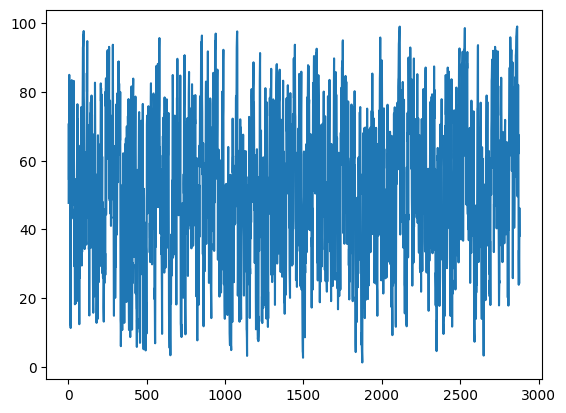

<Axes: >

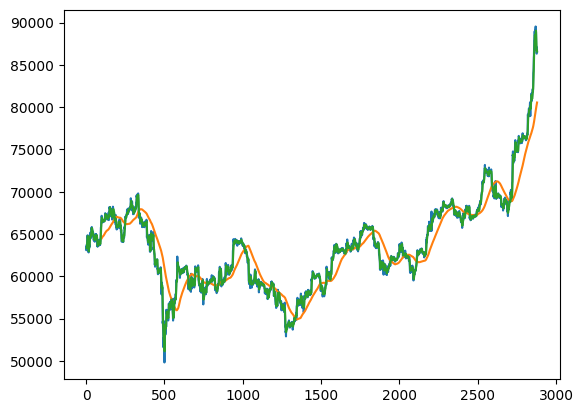

In [122]:
strategy1.df['rsi'].plot()
plt.show()
strategy1.df['current_px'].plot()
strategy1.df['px_lma'].plot()
strategy1.df['px_sma'].plot()

In [123]:
strategy1.summary(True)

,Measure,mrr_530621
0,Pnl,-10.4152
1,Trading Fee,-5.5953
2,Pnl Gross,-4.8198
3,Cumulative Return,0.8958
4,Annualized Return,-0.6249
5,Annualized Volatility,0.1068
6,Annualized Sharpe Ratio,-6.2488
7,Maximum Drawdown,-0.1125


# Execute Strategy

Strategy ID - all orders are marked by strategy id

Therefore, all orders / pnl logic are based on same set of orders which isolates from other strategy or previous strategy

If we want to continue previous strategy (either manual exit or error exit), we need to put the same strategy id. so the pnl could be accumlated from last time.

<b>Notes: execute.py runs the actual strategy, below code is just to keep track the strategy status and performance</b>

In [32]:
setup = ExecuteSetup.read_all()
strategy_dict = dict()

In [33]:
for k, v in setup.items():    
    if v['status'] != STATUS.RUN.name:
        continue
    
    strategy = StrategyFactory().get(k)
    strategy.set_data_loder(DataLoaderBinance())
    strategy.set_executor(ExecutorBinance())
    strategy.set_strategy_id(k, reload=True)    
    if strategy.status == STATUS.RUN and str(type(strategy)) == str(GridArithmeticStrategy):
        strategy_dict[k] = strategy                                  

In [48]:
# pnl cutoff as 00:00 HKT
offset = 0
date = datetime.today()
date = datetime(year=date.year, month=date.month, day=date.day, tzinfo=ZoneInfo("HongKong")) - timedelta(days=offset)
date_str = date.strftime('%Y-%m-%d %H:%M:%S%z')
date_str_end = (date + timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S%z')

In [49]:
for k, v in strategy_dict.items():
    strategy = v
    strategy.load_data(date_str, lookback_end=date_str_end)    
    strategy.summary(True, lastn=20)

,Measure,grid_AEURUSDTv1
0,Pnl,-21.4791
1,Trading Fee,-0.0000
2,Pnl Gross,-21.4791
3,Cumulative Return,0.9946
4,Annualized Return,-2.3997
5,Annualized Volatility,0.0636
6,Annualized Sharpe Ratio,-38.4953
7,Maximum Drawdown,-0.0055


# Historical PnL

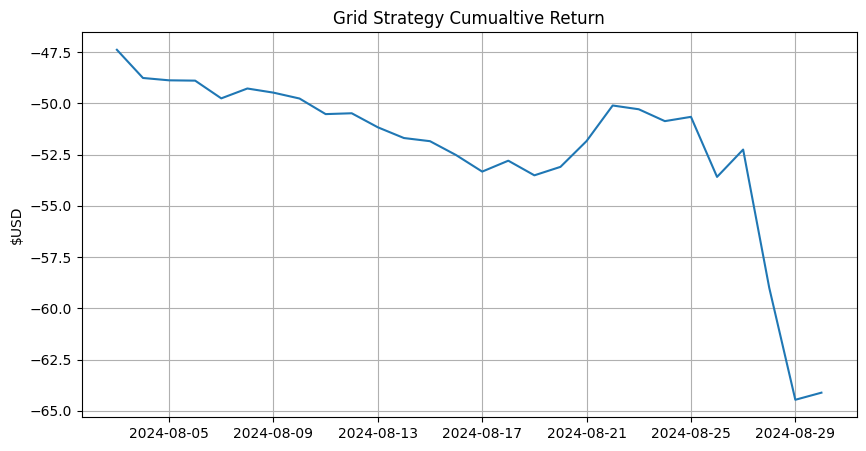

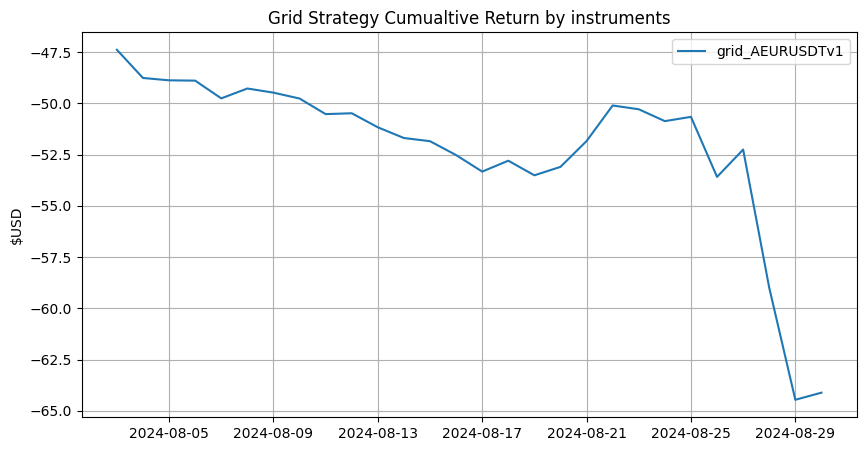

In [43]:
pnl = []
for strategy in strategy_dict.values():
    pnl.append(strategy.get_pnl())

plt.figure(figsize=(10,5))
pnl = pd.concat(pnl)
pnl_all = pnl.groupby(['Date']).sum(numeric_only=True)
pnl_all['pnl_cum'] = pnl_all['pnl'].cumsum()
#pnl_all['pnl_cum'] = pnl_all['trading_fee'].cumsum()

pnl_all.sum(numeric_only=True)
plt.plot(pnl_all['pnl_cum'])
plt.title('Grid Strategy Cumualtive Return')
plt.grid()
plt.ylabel('$USD')
plt.show()

plt.figure(figsize=(10,5))
pnl_strategy = pnl.groupby(['Date', 'strategy']).sum(numeric_only=True).reset_index()
for s in pnl_strategy['strategy'].unique():
    t = pnl_strategy[pnl_strategy['strategy'] == s]
    t['pnl_cum'] = t['pnl'].cumsum()
    plt.plot(t['Date'], t['pnl_cum'], label=s)

plt.title('Grid Strategy Cumualtive Return by instruments')
plt.legend()
plt.grid()
plt.ylabel('$USD')
plt.show()
